# Modelos de regresión

In [39]:
!pip install gpboost
!pip install shap
!pip install xgboost
!pip install geopandas
!pip install contextily
!pip install pysal

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt
import contextily

# Modelos
import gpboost as gpb
import shap
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler


## Lectura de datos 

In [41]:
data = pd.read_csv('https://raw.githubusercontent.com/alessiobocco/Diplo_Eco/main/data/modelling_data.csv',  index_col=[0])

In [42]:
data.head()

,id,antig,m2total,m2cub,ambientes,banios,precioUSD,m2precioUSD,comisaria_dista,obelisco_dista,nrobos,sup_espacio_verde,count_culturales,lon_planar,lat_planar,comunas,barrios,densidad_poblacional,densidad_viviendas,distritos,SobreAvenida,Aestrenar,monoambiente,count_gastronomia,count_educacion,count_roads,count_salud,count_transporte,SonCosteros,zonas_EAH,cardinality,clusters,lagged_ambientes,lagged_banios,lagged_antig,lagged_m2total,lagged_m2cub,lagged_comisaria_dista,lagged_obelisco_dista,lagged_nrobos,lagged_sup_espacio_verde,lagged_count_gastronomia,lagged_count_educacion,lagged_count_roads,lagged_count_salud,lagged_count_transporte,geometry
0,1,0,200,200,0.0,0,1500000,7500.000000,1162.621600,14053.797191,134,68426.445,0,-6.515379e+06,-4.114971e+06,9,LINIERS,9162.535077,3428.444997,NO CARACTERIZADO,1,1,1,52.0,16.0,7.0,6.0,2.0,0.0,Sur,8,0,1.125,1.50,8.75,126.75,121.75,1085.739334,13773.804542,166.875,74085.514625,55.75,20.875,11.75,10.875,1.125,POINT (-6515379.180859259 -4114970.853546773)
1,6,0,20,20,0.0,0,43000,2150.000000,832.171100,13886.649121,134,85899.037,0,-6.515279e+06,-4.114576e+06,9,LINIERS,9162.535077,3428.444997,NO CARACTERIZADO,0,1,1,19.0,12.0,13.0,2.0,1.0,0.0,Sur,4,0,0.000,0.75,22.50,313.50,313.50,853.390667,13751.345785,118.750,83858.444500,33.50,14.500,13.00,6.750,0.750,POINT (-6515278.659359072 -4114576.319074007)
2,8,97,268,268,0.0,0,390000,1455.223881,1711.006598,14133.532780,58,61231.550,0,-6.515252e+06,-4.115700e+06,9,LINIERS,9162.535077,3428.444997,NO CARACTERIZADO,0,0,1,20.0,1.0,0.0,2.0,1.0,0.0,Sur,2,-1,0.000,3.00,20.50,269.00,258.00,1711.886313,14124.218444,57.000,61292.294000,20.50,0.500,0.00,2.000,1.000,POINT (-6515251.60872281 -4115700.427085229)
3,9,1,270,270,0.0,4,390000,1444.000000,1704.004426,14126.937096,59,60861.066,0,-6.515246e+06,-4.115693e+06,9,LINIERS,9162.535077,3428.444997,NO CARACTERIZADO,0,0,0,21.0,1.0,0.0,2.0,1.0,0.0,Sur,2,-1,0.000,1.00,68.50,268.00,257.00,1715.387399,14127.516286,56.500,61477.536000,20.00,0.500,0.00,2.000,1.000,POINT (-6515245.708789796 -4115692.849668185)
4,10,40,268,246,0.0,2,360000,1463.000000,1719.768199,14121.499792,55,61723.522,0,-6.515231e+06,-4.115715e+06,9,LINIERS,9162.535077,3428.444997,NO CARACTERIZADO,0,0,0,20.0,0.0,0.0,2.0,1.0,0.0,Sur,2,-1,0.000,2.00,49.00,269.00,269.00,1707.505512,14130.234938,58.500,61046.308000,20.50,1.000,0.00,2.000,1.000,POINT (-6515231.237255995 -4115715.040689695)


In [43]:
data.loc[:,"comunas"] = data.comunas.astype(str)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3670 entries, 0 to 3669
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        3670 non-null   int64  
 1   antig                     3670 non-null   int64  
 2   m2total                   3670 non-null   int64  
 3   m2cub                     3670 non-null   int64  
 4   ambientes                 3629 non-null   float64
 5   banios                    3670 non-null   int64  
 6   precioUSD                 3670 non-null   int64  
 7   m2precioUSD               3670 non-null   float64
 8   comisaria_dista           3670 non-null   float64
 9   obelisco_dista            3670 non-null   float64
 10  nrobos                    3670 non-null   int64  
 11  sup_espacio_verde         3670 non-null   float64
 12  count_culturales          3670 non-null   int64  
 13  lon_planar                3670 non-null   float64
 14  lat_plan

In [45]:
data['geometry'] = data['geometry'].apply(wkt.loads)
geo_data = gpd.GeoDataFrame(data, crs='epsg:3857').to_crs(epsg=4326)

In [46]:
y = data.precioUSD
y_log = np.log(data.precioUSD)
X = data.drop(["precioUSD", "id", "m2precioUSD", "lon_planar", "lat_planar", "densidad_viviendas"], axis = 1)

In [47]:
X.head()

,antig,m2total,m2cub,ambientes,banios,comisaria_dista,obelisco_dista,nrobos,sup_espacio_verde,count_culturales,comunas,barrios,densidad_poblacional,distritos,SobreAvenida,Aestrenar,monoambiente,count_gastronomia,count_educacion,count_roads,count_salud,count_transporte,SonCosteros,zonas_EAH,cardinality,clusters,lagged_ambientes,lagged_banios,lagged_antig,lagged_m2total,lagged_m2cub,lagged_comisaria_dista,lagged_obelisco_dista,lagged_nrobos,lagged_sup_espacio_verde,lagged_count_gastronomia,lagged_count_educacion,lagged_count_roads,lagged_count_salud,lagged_count_transporte,geometry
0,0,200,200,0.0,0,1162.621600,14053.797191,134,68426.445,0,9,LINIERS,9162.535077,NO CARACTERIZADO,1,1,1,52.0,16.0,7.0,6.0,2.0,0.0,Sur,8,0,1.125,1.50,8.75,126.75,121.75,1085.739334,13773.804542,166.875,74085.514625,55.75,20.875,11.75,10.875,1.125,POINT (-6515379.181 -4114970.854)
1,0,20,20,0.0,0,832.171100,13886.649121,134,85899.037,0,9,LINIERS,9162.535077,NO CARACTERIZADO,0,1,1,19.0,12.0,13.0,2.0,1.0,0.0,Sur,4,0,0.000,0.75,22.50,313.50,313.50,853.390667,13751.345785,118.750,83858.444500,33.50,14.500,13.00,6.750,0.750,POINT (-6515278.659 -4114576.319)
2,97,268,268,0.0,0,1711.006598,14133.532780,58,61231.550,0,9,LINIERS,9162.535077,NO CARACTERIZADO,0,0,1,20.0,1.0,0.0,2.0,1.0,0.0,Sur,2,-1,0.000,3.00,20.50,269.00,258.00,1711.886313,14124.218444,57.000,61292.294000,20.50,0.500,0.00,2.000,1.000,POINT (-6515251.609 -4115700.427)
3,1,270,270,0.0,4,1704.004426,14126.937096,59,60861.066,0,9,LINIERS,9162.535077,NO CARACTERIZADO,0,0,0,21.0,1.0,0.0,2.0,1.0,0.0,Sur,2,-1,0.000,1.00,68.50,268.00,257.00,1715.387399,14127.516286,56.500,61477.536000,20.00,0.500,0.00,2.000,1.000,POINT (-6515245.709 -4115692.850)
4,40,268,246,0.0,2,1719.768199,14121.499792,55,61723.522,0,9,LINIERS,9162.535077,NO CARACTERIZADO,0,0,0,20.0,0.0,0.0,2.0,1.0,0.0,Sur,2,-1,0.000,2.00,49.00,269.00,269.00,1707.505512,14130.234938,58.500,61046.308000,20.50,1.000,0.00,2.000,1.000,POINT (-6515231.237 -4115715.041)


In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3670 entries, 0 to 3669
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   antig                     3670 non-null   int64   
 1   m2total                   3670 non-null   int64   
 2   m2cub                     3670 non-null   int64   
 3   ambientes                 3629 non-null   float64 
 4   banios                    3670 non-null   int64   
 5   comisaria_dista           3670 non-null   float64 
 6   obelisco_dista            3670 non-null   float64 
 7   nrobos                    3670 non-null   int64   
 8   sup_espacio_verde         3670 non-null   float64 
 9   count_culturales          3670 non-null   int64   
 10  comunas                   3670 non-null   object  
 11  barrios                   3670 non-null   object  
 12  densidad_poblacional      3670 non-null   float64 
 13  distritos                 3670 non-null   object

## Modelos dummy

In [261]:
from sklearn.dummy import DummyRegressor

# Regresion dummay
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X[variable_names], y)
y_pred = dummy_regr.predict(X[variable_names])

# Error de prediccion
RMSLE(y, y_pred)

446032.0987622788

Se utiliza como baseline para comparar los resultados de los distintos modelos. 

## Modelos econométricos

In [49]:
variable_names = [
    'antig',    
    'm2total',   
    'm2cub',     
    #'ambientes', 
    'banios',
    'comisaria_dista',
    'obelisco_dista',
    'nrobos',
    'sup_espacio_verde',
    'count_culturales',
    'count_educacion',
    'count_roads',
    'count_salud',
    'count_transporte',
    'cardinality',
    'clusters',
    # Variables binarias
    'SobreAvenida',
    'Aestrenar',
    'monoambiente',
    'SonCosteros'
]

In [50]:
from pysal.model import spreg

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


La primera prueba corresponde a una regresión lineal simple por mínimos cuadrados sin considerar la relación espacial entre las observaciones

In [51]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    y_log.values, 
    # Independent variables
    X[variable_names].values,
    # Dependent variable name
    name_y='log_price', 
    # Independent variable name
    name_x=variable_names
)

In [52]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        3670
Mean dependent var  :     12.4399                Number of Variables   :          20
S.D. dependent var  :      0.9390                Degrees of Freedom    :        3650
R-squared           :      0.5611
Adjusted R-squared  :      0.5589
Sum squared residual:    1419.645                F-statistic           :    245.6366
Sigma-square        :       0.389                Prob(F-statistic)     :           0
S.E. of regression  :       0.624                Log likelihood        :   -3464.649
Sigma-square ML     :       0.387                Akaike info criterion :    6969.297
S.E of regression ML:      0.6220                Schwarz criterion     :    7093.456

-----------------------------------------------------------------------------

El modelo lineal explica poco más del 55% de la variabilidad presente en los datos. Con respecto a la significancia de las variables, no todas son significativas como la distancia a las comisarias, la superficie de espacios verdes, el acceso a avenidas, entre otros. 

Claramente la antigüedad y la superficie están muy ligados al precio de venta del local independientemente de la ubicación del mismo. Al trabajar con una relación log - lin, las anteriores variables se interpretan como: un aumento de la antiguedad del inmueble de un año dismininuye su valor un 0.6% (100 * beta_antig), mientras que para la superficie, cada metro cuadrado extra aumenta el valor en un 0.3%. 

Cómo se observa en la evaluación de los supuestos del modelo, la varianza de los residuos no es constante lo que ya sugiere una dependencia espacial de algún tipo. 

In [53]:
evaluacion_regresion = data.copy()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


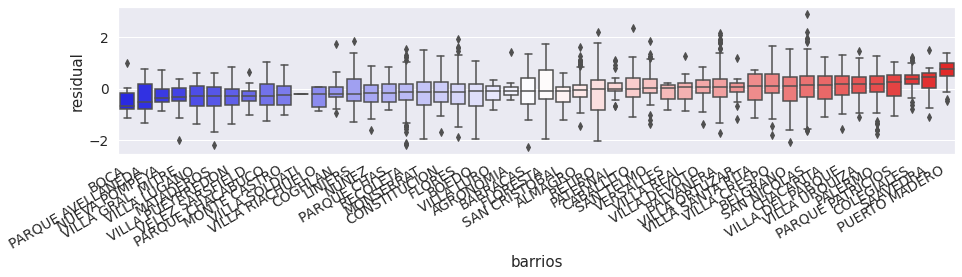

In [54]:
# Create column with residual values from m1
evaluacion_regresion['residual'] = m1.u
# Obtain the median value of residuals in each neighbourhood
medians = evaluacion_regresion.groupby(
    "barrios"
).residual.median().to_frame(
    'hood_residual'
)

# Increase fontsize
sns.set(font_scale = 1.25)
# Set up figure
f = plt.figure(figsize=(15,3))
# Grab figure's axis
ax = plt.gca()
# Generate bloxplot of values by neighbourhood
# Note the data includes the median values merged on-the-fly
sns.boxplot(
    'barrios', 
    'residual', 
    ax = ax,
    data=evaluacion_regresion.merge(
        medians, 
        how='left',
        left_on='barrios',
        right_index=True
    ).sort_values(
        'hood_residual'), palette='bwr'
)
# Auto-format of the X labels
f.autofmt_xdate()
# Display
plt.show()

Los residuos por barrio muestran que hay algunos, como Puerto Madero, cuyo precio es fuertemente subestimado por el modelo lineal. 

In [270]:
from pysal.lib import weights
from pysal.explore import esda

In [271]:
# Calcular matriz de pesos espaciales
w = weights.KNN.from_dataframe(geo_data, k = 20)

Cálculo de la matriz de pesos espaciales

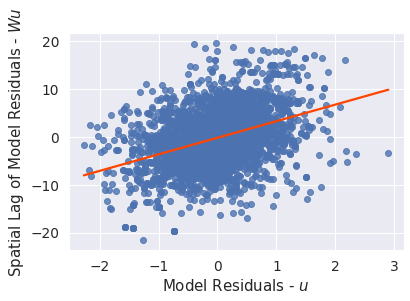

In [57]:
lag_residual = weights.spatial_lag.lag_spatial(w, m1.u)
ax = sns.regplot(
    m1.u.flatten(), 
    lag_residual.flatten(), 
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

Existe una relación entre la ubicación de los locales y los residuos. Claramente hay una dependencia espacial que el modelo no es capaz de capturar. 

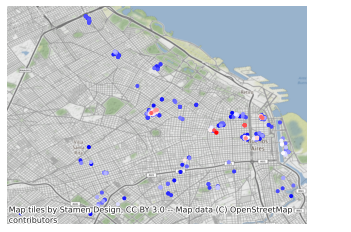

In [58]:
# Row-standardization
w.transform = 'R'
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, w, permutations=9999)
# Select only LISA cluster cores
error_clusters = (outliers.q % 2 == 1)
# Filter out non-significant clusters
error_clusters &= (outliers.p_sim <= .001)
# Add `error_clusters` and `local_I` columns
ax = geo_data.assign(
    error_clusters = error_clusters,
    local_I = outliers.Is
# Retain error clusters only
).query(
    "error_clusters"
# Sort by I value to largest plot on top
).sort_values(
    'local_I'
# Plot I values
).plot(
    'local_I', cmap='bwr', marker='.'
)
# Add basemap
contextily.add_basemap(ax, crs=geo_data.crs)
# Remove axes
ax.set_axis_off();

Los puntos azules muestran los locales cuyo precio es subestimado y los rojos, viceversa. No se muestran todos dado que sólo se plotean aquellos que tienen dependencia con sus vecinos. Es decir, donde el modelo sistemáticamente subestima o sobreestima los resultados. 

In [59]:
# Set up table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        'Coeff.': m1.betas.flatten(),
        # Pull out and flatten standard errors
        'Std. Error': m1.std_err.flatten(),
        # Pull out P-values from t-stat object
        'P-Value': [i[1] for i in m1.t_stat]
    },
    index=m1.name_x
)

,Coeff.,Std. Error,P-Value
CONSTANT,1.182384e+01,8.201248e-02,0.000000e+00
antig,-6.003884e-03,8.775083e-04,9.122117e-12
m2total,3.604079e-03,1.681550e-04,4.354565e-96
m2cub,5.806954e-04,1.784981e-04,1.151405e-03
banios,4.726144e-02,8.684618e-03,5.616197e-08
comisaria_dista,-3.659983e-05,3.264737e-05,2.623338e-01
obelisco_dista,-1.413248e-05,5.068775e-06,5.328528e-03
nrobos,-7.085872e-04,2.550143e-04,5.486997e-03
sup_espacio_verde,1.635873e-07,1.420781e-07,2.496472e-01
count_culturales,4.903841e-03,1.033407e-03,2.161638e-06


Modelo espacial con efectos fijos

In [65]:
# PySAL spatial fixed effect implementation
m3 = spreg.OLS_Regimes(
    # Dependent variable
    y_log.values, 
    # Independent variables
    X[variable_names].values,
    # Variable specifying neighborhood membership
    X['comunas'].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi='many',
    # Variables to be allowed to vary (True) or kept
    # constant (False). Here we set all to False
    cols2regi=[False]*len(variable_names),
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False, # Da error. Tengo que averiguar el motivo. Falla el cálculo
    # Dependent variable name
    name_y='precioUSD', 
    # Independent variables names
    name_x=variable_names
)

Se ajuste una constante por cada comuna para considerar el efecto de la ubicación del local sobre el precio.

In [272]:
neighborhood_effects = m2.params.filter(like='comunas')
neighborhood_effects.head()

comunas[1]      96133.476842
comunas[10]     78078.950707
comunas[11]    105365.492442
comunas[12]    164528.993801
comunas[13]    103917.333024
dtype: float64

In [68]:
# Create a sequence with the variable names without
# `neighborhood[` and `]`
stripped = neighborhood_effects.index.str.strip(
    'comunas['
).str.strip(']')
# Reindex the neighborhood_effects Series on clean names
neighborhood_effects.index = stripped
# Convert Series to DataFrame
neighborhood_effects = neighborhood_effects.to_frame('fixed_effect')
# Print top of table
neighborhood_effects.sort_values(by = 'fixed_effect')

,fixed_effect
8,-38497.450076
2,24532.025253
4,62914.920988
14,63865.004336
10,78078.950707
5,80353.561154
3,82527.199102
9,83477.734158
1,96133.476842
13,103917.333024


In [69]:
# Descargar geojson de la base de datos del gobierno de CABA
url = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson"
barrios = gpd.read_file(url).to_crs(epsg=3857)
# Elegir las columnas de interes
barrios = barrios[["BARRIO", "COMUNA", "geometry"]]
# Corregir nombres de variables
barrios = barrios.rename(columns = {"BARRIO" : "barrios", "COMUNA" : "comunas"})
barrios['comunas'] = barrios.comunas.astype(float).astype(int).astype(str)

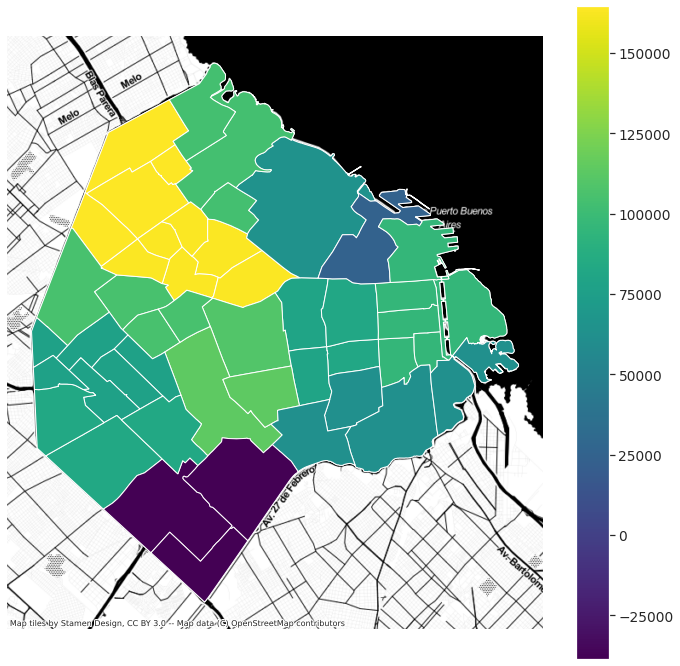

In [70]:
efectos_fijos = barrios.merge(
    neighborhood_effects, 
    how='left',
    left_on='comunas', 
    right_index=True
# Drop polygons without a SFE estimate
).dropna(
    subset=['fixed_effect'])
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot neighbourhoods
barrios.plot(ax=ax, )
# Plot POIs in red
efectos_fijos.plot(ax=ax, column='fixed_effect', legend=True, cmap = 'viridis')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=barrios.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

El mapa muestra la constante correspondiente a cada barrio en función del modelo estimado. 

In [273]:
# PySAL spatial fixed effect implementation
m4 = spreg.OLS_Regimes(
    # Dependent variable
    y.values, 
    # Independent variables
    X[variable_names].values,
    # Variable specifying neighborhood membership
    X['comunas'].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi='many',
    # Variables to be allowed to vary (True) or kept
    # constant (False). Here we set all to False
    cols2regi=[False]*len(variable_names),
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False, # Da error. Tengo que averiguar el motivo. Falla el cálculo
    # Dependent variable name
    name_y='precioUSD', 
    # Independent variables names
    name_x=variable_names
)

In [274]:
# Definicion de la funcion de pérdida del RMSE
def RMSLE(y, y_pred):
    """ 
    Función de costo del rmse
    """
    return (np.sqrt(mean_squared_error(y, y_pred)))

In [275]:
RMSLE(y, m4.predy)

315686.60442901443

El modelo econométrico con efectos fijos mejora los resultados con respecto a la regresión dummy. 

#### Modelo econométrico espacial

In [276]:
# PySAL spatial fixed effect implementation
m1 = spreg.OLS(
    # Dependent variable
    y.values, 
    # Independent variables
    X[variable_names].values,
    # Dependent variable name
    name_y='precioUSD', 
    # Independent variables names
    name_x=variable_names,
    w=w, spat_diag=True,
)

In [277]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   precioUSD                Number of Observations:        3670
Mean dependent var  : 391447.7311                Number of Variables   :          20
S.D. dependent var  : 446092.8785                Degrees of Freedom    :        3650
R-squared           :      0.4952
Adjusted R-squared  :      0.4926
Sum squared residual:368545822737312.500                F-statistic           :    188.4748
Sigma-square        :100971458284.195                Prob(F-statistic)     :           0
S.E. of regression  :  317760.064                Log likelihood        :  -51692.897
Sigma-square ML     :100421205105.535                Akaike info criterion :  103425.795
S.E of regression ML: 316893.0499                Schwarz criterion     :  103549.954

--------------------------------------------------------------

In [278]:
RMSLE(y, m1.predy)

316893.0499482984

El modelo econométrico espacial no mejora en gran medida con respecto a la regresión con efectos fijos. 

## Modelos de aprendizaje automático

In [ ]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [71]:
X = data

In [72]:
from sklearn.model_selection import train_test_split

def get_min_required_rows(test_size=0.2):
    return 1 / test_size

def make_stratified_splits(df, y_col="label", test_size=0.2):
    """
        for any class with rows less than min_required_rows corresponding to the input test_size,
        all the rows associated with the specific class will have a copy in both the train and test splits.
        
        example: if test_size is 0.2 (20% otherwise),
        min_required_rows = 5 (which is obtained from 1 / test_size i.e., 1 / 0.2)
        where the resulting splits will have 4 train rows (80%), 1 test row (20%)..
    """
    
    id_col = "id"
    temp_col = "same-class-rows"
    
    class_to_counts = df[y_col].value_counts()
    df[temp_col] = df[y_col].apply(lambda y: class_to_counts[y])
    
    min_required_rows = get_min_required_rows(test_size)
    copy_rows = df[df[temp_col] < min_required_rows].copy(deep=True)
    valid_rows = df[df[temp_col] >= min_required_rows].copy(deep=True)
    
    X = valid_rows[id_col].tolist()
    y = valid_rows[y_col].tolist()
    
    # notice, this train_test_split is a stratified split
    X_train, X_test, _, _ = train_test_split(X, y, test_size=test_size, random_state=43, stratify=y)
    
    X_test = X_test + copy_rows[id_col].tolist()
    X_train = X_train + copy_rows[id_col].tolist()
    
    df.drop([temp_col], axis=1, inplace=True)
    
    test_df = df[df[id_col].isin(X_test)].copy(deep=True)
    train_df = df[df[id_col].isin(X_train)].copy(deep=True)
    
    print (f"number of rows in the original dataset: {len(df)}")
    
    test_prop = round(len(test_df) / len(df) * 100, 2)
    train_prop = round(len(train_df) / len(df) * 100, 2)
    print (f"number of rows in the splits: {len(train_df)} ({train_prop}%), {len(test_df)} ({test_prop}%)")
    
    return train_df, test_df

In [229]:
train_data, test_data = make_stratified_splits(data, y_col="barrios", test_size=0.3)

number of rows in the original dataset: 3670
number of rows in the splits: 2569 (70.0%), 1102 (30.03%)


In [230]:
coords_train = train_data[['lon_planar', 'lat_planar']]
coords_test = test_data[['lon_planar', 'lat_planar']]

In [231]:
drop_features = ['id', 'lon_planar', 'lat_planar', 'comunas', 'geometry']
train_data = train_data.drop(drop_features, axis = 1)
test_data = test_data.drop(drop_features, axis = 1)

In [232]:
y_train = train_data.precioUSD
y_test = test_data.precioUSD

# Eliminar target del dataset
X_train = train_data.drop('precioUSD', axis = 1)
X_test = test_data.drop('precioUSD', axis = 1)

In [234]:
variables = train_data.columns

In [235]:
numerical_variables = ['antig', 'm2total', 'm2cub', 'banios', 
                      'comisaria_dista', 'obelisco_dista', 'nrobos', 'sup_espacio_verde',
                      'count_gastronomia', 'count_educacion', 'count_roads', 'count_salud',
                      'count_transporte', 'cardinality', 
                      'lagged_banios', 'lagged_antig', 'lagged_m2total',
                      'lagged_m2cub', 'lagged_comisaria_dista', 'lagged_obelisco_dista',
                      'lagged_nrobos', 'lagged_sup_espacio_verde', 'lagged_count_gastronomia',
                      'lagged_count_educacion', 'lagged_count_roads', 'lagged_count_salud',
                      'lagged_count_transporte']

categorical_variable = ['clusters', 'distritos', 'SobreAvenida', 'Aestrenar', 'monoambiente', 'zonas_EAH', 'SonCosteros', 'barrios']

Escalado de variables

In [236]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

## Aplicamos la transformación de escala sobre los features
scaler_X.fit(X_train[numerical_variables])
X_scaled_train = pd.DataFrame(scaler_X.fit_transform(X_train[numerical_variables]), columns = numerical_variables)
X_scaled_test  = pd.DataFrame(scaler_X.fit_transform(X_test[numerical_variables]), columns = numerical_variables)

## Aplicamos la transformación de escala sobre la variable objetivo
## Observación: StandardScaler toma como input una matriz. Si queremos darle un
## vector (como por ej. para utilizar con la variable objetivo), tenemos que 
## transformar ese vector en una matriz de una sola columna. Esto lo hacemos
## con el método 'reshape'
scaler_y.fit(y_train.values.reshape(-1, 1))
y_scaled_train = scaler_y.transform(y_train.values.reshape(-1, 1))[:,0]
y_scaled_test  = scaler_y.transform(y_test.values.reshape(-1, 1))[:,0]

In [237]:
train_dummy_variables = pd.get_dummies(X_train[categorical_variable], dummy_na=True)
test_dummy_variables = pd.get_dummies(X_test[categorical_variable], dummy_na=True)

In [240]:
X_scaled_train = pd.concat([X_scaled_train.reset_index(drop=True), train_dummy_variables.reset_index(drop=True)], axis=1)
variable_names_train = X_scaled_train.columns
X_scaled_test = pd.concat([X_scaled_test.reset_index(drop=True), test_dummy_variables.reset_index(drop=True)], axis=1)

In [241]:
X_scaled_train = np.array(X_scaled_train)
X_scaled_test = np.array(X_scaled_test)

### XGBoost

In [211]:
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE

In [212]:
# import packages for hyperparameters tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_squared_error
import time

In [242]:
# Definicion de la funcion de pérdida del RMSE
def RMSLE(y, y_pred):
    """ 
    Función de costo del rmse
    """
    return (np.sqrt(mean_squared_error(y, y_pred)))

# Definicion del scoring para usar en la validación
rmsle_loss = make_scorer(RMSLE, greater_is_better=False)

In [243]:
param_grid={"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
             "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
             "min_child_weight" : [ 1, 3, 5, 7 ],
             "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
             "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

model = xg.XGBRegressor()

In [244]:
# Configuración de la validación cruzada anidada
cv_outer = KFold(n_splits=3, shuffle=True, random_state=1)
# Iterar por las divisiones del dataset original
rmse_train_results = list() # Guardar el error de train
rmse_test_results = list() # Guardar el error de test
best_score = float("+inf") # Indicador para elegir el mejor ajuste

for train_ix, test_ix in cv_outer.split(X_scaled_train):
    # Comienzo del contador
    start = time.time()
    # Dividir los datos. El set de train se subdivide en una nueva muestra de train y test
    X_train_outer, X_test_outer = X_scaled_train[train_ix, :], X_scaled_train[test_ix, :]
    y_train_outer, y_test_outer = y_scaled_train[train_ix], y_scaled_train[test_ix]
    
    # Configuración de la validacion interna
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

    # Definir la busqueda
    search = RandomizedSearchCV(model, param_grid, scoring=rmsle_loss, cv=cv_inner, n_iter = 100,
                                refit=True, verbose = 1, n_jobs = -1)
    # Ejecutar busqueda
    result = search.fit(X_train_outer, y_train_outer)
    # Seleccionar el mejor modelo para esa submuestra
    best_model_iteration = result.best_estimator_
    # Evaluar el modelo elegido con los datos de test de la submuestra
    pred_train = scaler_y.inverse_transform(best_model_iteration.predict(X_train_outer).reshape(-1, 1))
    pred_test  = scaler_y.inverse_transform(best_model_iteration.predict(X_test_outer).reshape(-1, 1))
    # Convertir la variable objetivo a su escala original
    train_rescaled = scaler_y.inverse_transform(y_train_outer.reshape(-1, 1))
    test_rescaled  = scaler_y.inverse_transform(y_test_outer.reshape(-1, 1))
    # Calcular métricas de error
    train_rmse_values = RMSLE(pred_train, train_rescaled)
    test_rmse_values = RMSLE(pred_test, test_rescaled)
    # Evaluar el modelo. Si la performance en test mejora, se selecciona
    if best_score > test_rmse_values:
        best_model = result.best_estimator_
        best_score = test_rmse_values
    # Guardar resultados del error en cada iteración
    rmse_train_results.append(train_rmse_values)
    rmse_test_results.append(test_rmse_values)
    # Reporte de progreso
    print('>RMSE_train=%.3f, RMSE_test=%.3f score = %.3f, param = %s' % (train_rmse_values, test_rmse_values, result.best_score_, result.best_params_))
    
    # Finalizar contador
    stop = time.time()
    print("La iteración tomó", round(stop-start, 3), "segundos.")


# Resumen de la perfomance del modelo
print('RMSE_train: %.3f (%.3f)' % (np.mean(rmse_train_results), np.std(rmse_train_results)))
print('RMSE_test: %.3f (%.3f)' % (np.mean(rmse_test_results), np.std(rmse_test_results)))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[23:28:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
>RMSE_train=12969.008, RMSE_test=302840.866 score = -0.548, param = {'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.0, 'colsample_bytree': 0.4}
La iteración tomó 146.25 segundos.
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[23:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
>RMSE_train=88062.730, RMSE_test=249293.247 score = -0.545, param = {'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.4}
La iteración tomó 161.773 segundos.
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[23:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
>RMSE_train=75545.626

In [245]:
# Ajustar el modelo con todos los datos
best_model.fit(X_scaled_train, y_scaled_train)

[23:33:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.4, gamma=0.3, learning_rate=0.2, max_depth=5)

In [246]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_train = scaler_y.inverse_transform(best_model.predict(X_scaled_train).reshape(-1, 1))
pred_test  = scaler_y.inverse_transform(best_model.predict(X_scaled_test).reshape(-1, 1))

print('Train RMSE:', RMSLE(pred_train, y_train))
print('Test RMSE:', RMSLE(pred_test, y_test))

Train RMSE: 93326.32629207603
Test RMSE: 316153.19701736036


El error del modelo en los datos de test es de USD 316.000. Esto sugiere que existe una gran cantidad de variaibilidad que no es capturada. 

In [253]:
base_imp = imp_df(variable_names_train,  best_model.feature_importances_)

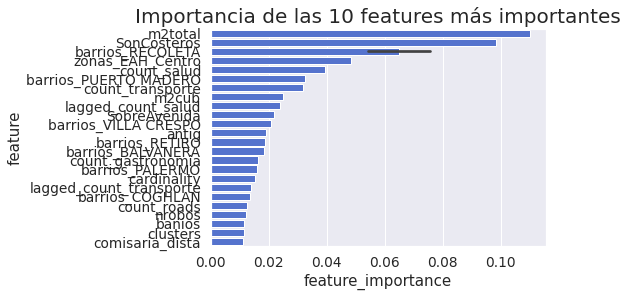

In [260]:
var_imp_plot(base_imp.head(25), 'Importancia de las 25 features más importantes')

Al igual que con el modelo lineal, la variable más importante fue la superficie ocupada por el local. También se suman otras, como si el barrio se encuentra sobre el río de la Plata o no y si el local se encuentra en el barrio de Recoleta. Por último, la comunas que el GCBA categoriza como zona centro en función de sus características socioeconómicas también tiene una gran influencia. 

### Random Forest

In [224]:
from sklearn.ensemble import RandomForestRegressor

In [256]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestRegressor()


In [257]:
# Configuración de la validación cruzada anidada
cv_outer = KFold(n_splits=3, shuffle=True, random_state=1)
# Iterar por las divisiones del dataset original
rmse_train_results = list() # Guardar el error de train
rmse_test_results = list() # Guardar el error de test
best_score = float("+inf") # Indicador para elegir el mejor ajuste

for train_ix, test_ix in cv_outer.split(X_scaled_train):
    # Comienzo del contador
    start = time.time()
    # Dividir los datos. El set de train se subdivide en una nueva muestra de train y test
    X_train_outer, X_test_outer = X_scaled_train[train_ix, :], X_scaled_train[test_ix, :]
    y_train_outer, y_test_outer = y_scaled_train[train_ix], y_scaled_train[test_ix]
    
    # Configuración de la validacion interna
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

    # Definir la busqueda
    search = RandomizedSearchCV(model, param_grid, scoring="neg_mean_squared_error", cv=cv_inner, n_iter = 100,
                                refit=True, verbose = 1, n_jobs = -1)
    # Ejecutar busqueda
    result = search.fit(X_train_outer, y_train_outer)
    # Seleccionar el mejor modelo para esa submuestra
    best_model_iteration = result.best_estimator_
    # Evaluar el modelo elegido con los datos de test de la submuestra
    pred_train = scaler_y.inverse_transform(best_model_iteration.predict(X_train_outer).reshape(-1, 1))
    pred_test  = scaler_y.inverse_transform(best_model_iteration.predict(X_test_outer).reshape(-1, 1))
    # Convertir la variable objetivo a su escala original
    train_rescaled = scaler_y.inverse_transform(y_train_outer.reshape(-1, 1))
    test_rescaled  = scaler_y.inverse_transform(y_test_outer.reshape(-1, 1))
    # Calcular métricas de error
    train_rmse_values = RMSLE(pred_train, train_rescaled)
    test_rmse_values = RMSLE(pred_test, test_rescaled)
    # Evaluar el modelo. Si la performance en test mejora, se selecciona
    if best_score > test_rmse_values:
        best_model = result.best_estimator_
        best_score = test_rmse_values
    # Guardar resultados del error en cada iteración
    rmse_train_results.append(train_rmse_values)
    rmse_test_results.append(test_rmse_values)
    # Reporte de progreso
    print('>RMSE_train=%.3f, RMSE_test=%.3f score = %.3f, param = %s' % (train_rmse_values, test_rmse_values, result.best_score_, result.best_params_))
    
    # Finalizar contador
    stop = time.time()
    print("La iteración tomó", round(stop-start, 3), "segundos.")


# Resumen de la perfomance del modelo
print('RMSE_train: %.3f (%.3f)' % (np.mean(rmse_train_results), np.std(rmse_train_results)))
print('RMSE_test: %.3f (%.3f)' % (np.mean(rmse_test_results), np.std(rmse_test_results)))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: ignored

In [ ]:
# Ajustar el modelo con todos los datos
best_model.fit(X_scaled_train, y_scaled_train)

In [ ]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_train = scaler_y.inverse_transform(best_model.predict(X_scaled_train).reshape(-1, 1))
pred_test  = scaler_y.inverse_transform(best_model.predict(X_scaled_test).reshape(-1, 1))

print('Train RMSE:', RMSLE(pred_train, y_train))
print('Test RMSE:', RMSLE(pred_test, y_test))

Feature importance

In [251]:
base_imp = imp_df(variable_names_train,  best_model.feature_importances_)

In [ ]:
var_imp_plot(base_imp, 'Importancia de cada feature')

### GPBoost

In [ ]:
gp_model = gpb.GPModel(gp_coords = coords_train, cov_function="exponential")
data_train = gpb.Dataset(X_scaled_train, y_train)
params = { 'objective': 'regression_l2', 'verbose': 0 }
# Training
bst = gpb.train(params=params, train_set=data_train,
                gp_model=gp_model, num_boost_round=247)
gp_model.summary() # Estimated covariance parameters
# Prediction
pred = bst.predict(data=X_test, gp_coords_pred=coords_test,
                    predict_var=True)
# Sum the predictions of the trees and the GP
y_pred = pred['fixed_effect'] + pred['random_effect_mean']

In [ ]:
## Utilizaremos la raiz cuadrada del error cuadrático medio como 
## medida del error
def rmse(y1, y2):
    """
    Raiz cuadrada del error cuadrático medio.
    """
    return np.sqrt(mean_squared_error(y1, y2))

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_test  = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

In [ ]:
rmse(y_test, pred_test)

NameError: ignored

In [ ]:
shap_values = shap.TreeExplainer(bst).shap_values(X_train)
shap.summary_plot(shap_values, X_train)
shap.dependence_plot("m2total", shap_values, X_train)

NameError: ignored

In [ ]:
# --------------------Parameter tuning using a validation set----------------
# Define training and validation data by setting indices of 'folds'
n = len(X_train_
permut = np.random.RandomState(10).choice(a=n, size=n, replace=False)
train_idx = permut[0:int(n/2)]
valid_idx = permut[int(n/2):n]
folds = [(train_idx, valid_idx)]
# Parameter tuning using validation data
opt_params = gpb.grid_search_tune_parameters(param_grid=param_grid_small,
                                             params=params,
                                             folds=folds,
                                             gp_model=gp_model,
                                             use_gp_model_for_validation=True,
                                             train_set=data_train,
                                             verbose_eval=1,
                                             num_boost_round=1000, 
                                             early_stopping_rounds=10,
                                             seed=1000,
                                             metrics='binary_logloss')
print("Best number of iterations: " + str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))
print("Best parameters: " + str(opt_params['best_params']))

SyntaxError: ignored